In [1]:
import torch 
from torch import nn, optim
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import math 
import numpy as np
from PIL import Image
import cv2
from tqdm.notebook import tqdm 
from functools import partial

In [2]:
class DigitRecognizer(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(DigitRecognizer, self).__init__()
        self.input = nn.Linear(input_size, hidden_sizes[0])
        self.relu_0 = nn.ReLU()
        self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu_1 = nn.ReLU()
        self.output = nn.Linear(hidden_sizes[1], num_classes)
        
    def forward(self, X):
        model = self.input(X)
        model = self.relu_0(model)
        model = self.hidden1(model)
        model = self.relu_1(model)
        model = self.output(model)
        return model 

In [34]:
batch_size = 50
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST('./', download=True, train=True, transform=transform)
test_data = datasets.MNIST('./', download=True, train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False , num_workers=2)

In [4]:
model = torch.load('digit_classifier.pt')
model.eval()

DigitRecognizer(
  (input): Linear(in_features=784, out_features=128, bias=True)
  (relu_0): ReLU()
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (relu_1): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [601]:
epsilon_upper= 0

def eval_model(model, images):
    images = images.astype(np.float32)
    images = torch.from_numpy(images)
    images = images.reshape(-1, 784)
    outputs = model(images) 
    _, test_predicted = torch.max(outputs.data,1)
    return test_predicted.item()

def is_adversarial(oracle, target_class, image): 
    if oracle(image) != target_class: 
        return True 
    return False

def initial_adversarial(target_, advesarial_criterion):
    while True: 
        random_pertubation = np.random.uniform(0, 1,size = (28,28))
        if advesarial_criterion(random_pertubation): 
            return random_pertubation
    
def step_towards(target_, pertubation, epsilon):
    pertubation -= ((pertubation - target_) * epsilon)
    return pertubation
    
def orthogonal_pertubation(target_, pertubation, delta): 
    # iid random normal 
    new_pertubation = np.random.normal(0,1,size=(28,28))
    new_pertubation /= np.linalg.norm(new_pertubation)
    # || n_k||^2 = delta * dist(previous_adversarial, original_image), condition 2 
    new_pertubation *= delta * np.linalg.norm(pertubation - target_)
    new_pertubation += pertubation
    # condition 1
    new_pertubation = new_pertubation.clip(0,1)
    #projecting onto sphere 
    new_pertubation -= target_
    new_pertubation /= np.linalg.norm(new_pertubation)
    new_pertubation *= np.linalg.norm(pertubation - target_)
    new_pertubation += target_
    return new_pertubation
    
def adaptive_delta_descent(is_adversarial_fn, side_step_fn, adversarial_img): 
    lower_delta, upper_delta = 1,0
    delta = -1
    while abs(delta - upper_delta) > .01: 
        delta = (lower_delta + upper_delta)/2
        percent_adversarial = \
        np.mean([is_adversarial_fn( side_step_fn(adversarial_img, delta) )\
                 for i in range(10)])
        if percent_adversarial >= .5:
            lower_delta = delta #increasing delta 
        else: 
            upper_delta = delta # decreasing delta
    return delta
    
def adaptive_epsilon_descent(target, is_adversarial_fn, adversarial_img): 
    global epsilon_upper
    epsilon_lower = 1
    epsilon_upper = 0
    epsilon = (epsilon_lower + epsilon_upper)/2
    while abs(epsilon - epsilon_lower) > .01 or abs(epsilon - epsilon_upper) > .01: 
        epsilon = (epsilon_lower + epsilon_upper)/2
        new_pertubation = adversarial_img - ((adversarial_img - target) * epsilon)
        if is_adversarial_fn(new_pertubation):
            epsilon_upper = epsilon
        else: 
            epsilon_lower = epsilon
            
    new_pertubation = adversarial_img - ((adversarial_img - target) * epsilon_upper)
    return new_pertubation
    
    
def boundary_attack(model, oracle, target_, target_class, k):
    global epsilon_upper
    #create partials so to avoid passing in same parameters every time 
    # step_towards_(pertubation, epsilon)
    step_towards_= partial(step_towards, target_) 
    # oracle_(images)
    oracle_ = partial(oracle, model) 
    #is_adversarial_(image)
    is_adversarial_ = partial(is_adversarial, oracle_, target_class) 
    #orthogonal_pertubation_(pertubation, delta)
    orthogonal_pertubation_ = partial(orthogonal_pertubation, target_)
    #adaptive_epsilon_descent_(pertubation)
    adaptive_epsilon_descent_ = partial(adaptive_epsilon_descent, target_, is_adversarial_)
    #adaptive_delta_descent_(pertubation)
    adaptive_delta_descent_ = partial(adaptive_delta_descent, is_adversarial_, \
                                      orthogonal_pertubation_)
    
    # initial adversarial
    adversarial_img = initial_adversarial(target_, oracle_)
    #return adversarial_img
    adversarial_img = adaptive_epsilon_descent_(adversarial_img)#descent(adversarial_img,target_ )


    count = 0
    for i in tqdm(range(k)): 
        delta = adaptive_delta_descent_(adversarial_img)
        temp_adversarial_img = orthogonal_pertubation_(adversarial_img, delta)
        adversarial_img = adaptive_epsilon_descent_(adversarial_img)
        if is_adversarial_(temp_adversarial_img): 
            adversarial_img = temp_adversarial_img
            print(f'{epsilon_upper=}')
            count += 1
    return adversarial_img
    

In [576]:
def return_target_img(class_num, num): 
    temp = []
    for a, b in train_data: 
        if b == class_num: 
            temp.append(a)
        if len(temp)==num: 
            return temp 
        

In [603]:
target = return_target_img(8, 1)[0]

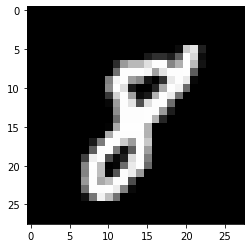

target_class=8


In [604]:
%matplotlib inline 
target = target.numpy().reshape((28,28))
target = target.astype(np.float32)
plt.imshow(target, cmap="gray")
plt.show()
target_class = eval_model(model, target)
print(f'{target_class=}')

In [605]:
final = boundary_attack(model, eval_model, target, target_class, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

epsilon_upper=0.078125
epsilon_upper=0.0703125
epsilon_upper=0.078125
epsilon_upper=0.078125
epsilon_upper=0.0703125
epsilon_upper=0.0078125
epsilon_upper=0.0390625
epsilon_upper=0.0078125
epsilon_upper=0.0078125
epsilon_upper=0.0234375
epsilon_upper=0.03125
epsilon_upper=0.03125
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1953125
epsilon_upper=0.1953125
epsilon_upper=0.203125
epsilon_upper=0.1953125
epsilon_upper=0.1953125
epsilon_upper=0.203125
epsilon_upper=0.1953125
epsilon_upper=0.1953125
epsilon_upper=0.1953125
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1953125
epsilon_upper=0.1953125
epsilon_upper=0.1953125
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1953125
epsilon_upper=0.1953125
epsilon_upper=0.1953125
epsilon_upper=0.1953125
epsilon_upper=0.1875
epsilon_upper=0.1875
epsilon_upper=0.1875
e

In [592]:
z = [upper, epsilon, lower]

In [596]:
epsilon

0.9453125

In [595]:
upper

0.9375

Adversarial class: 3 



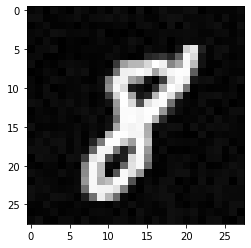

Adversarial class: 8 



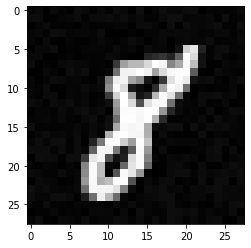

Adversarial class: 8 



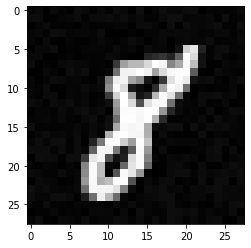

In [594]:
%matplotlib inline 

for i in z:
    temp = pertubation - ((pertubation - target) * i)
    plt.imshow(temp, cmap="gray")
    print(f'Adversarial class: {eval_model(model, temp)} \n')
    plt.show()

In [589]:
pertubation

array([[0.39776128, 0.64351605, 0.02453448, 0.75148447, 0.37463182,
        0.07410858, 0.91795041, 0.65896977, 0.24407044, 0.6759501 ,
        0.23609024, 0.93155485, 0.60168548, 0.04330926, 0.99494171,
        0.00894663, 0.4030875 , 0.93304005, 0.55587869, 0.5438313 ,
        0.85830223, 0.95506991, 0.04994439, 0.42286547, 0.34208658,
        0.31152608, 0.31231422, 0.70110621],
       [0.91047864, 0.88719944, 0.14148567, 0.19167308, 0.46067654,
        0.56943196, 0.8503325 , 0.27310329, 0.71426041, 0.7472008 ,
        0.95134614, 0.57818292, 0.91420882, 0.49611242, 0.74261028,
        0.28366794, 0.24490171, 0.7711299 , 0.99781276, 0.96715981,
        0.47384344, 0.51848051, 0.55701546, 0.69104207, 0.19008036,
        0.92870547, 0.27978442, 0.45408902],
       [0.08489475, 0.42647696, 0.79501794, 0.23992324, 0.21369027,
        0.3482753 , 0.0551828 , 0.4591849 , 0.16196242, 0.30811855,
        0.29837888, 0.46255656, 0.45930055, 0.01036968, 0.73833205,
        0.81021752, 0.4632

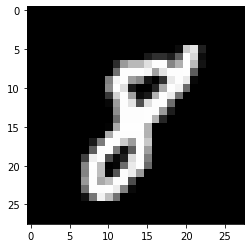

Image class: 8


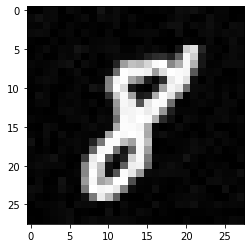

Adversarial class: 3 

L2 norm between images: 0.7406255443599422


In [606]:
%matplotlib inline 

plt.imshow(target, cmap="gray")
plt.show()
print(f'Image class: {eval_model(model, target)}')

 
plt.imshow(final, cmap="gray")
plt.show()
print(f'Adversarial class: {eval_model(model, final)} \n')


print(f'L2 norm between images: {np.linalg.norm(final -  target) }')

In [485]:
for i in range(10,0, -1):
    print(i)

10
9
8
7
6
5
4
3
2
1


2**i=1


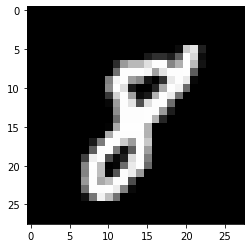

In [518]:
temp = final - (final - target)
plt.imshow(temp, cmap="gray")
print(f'{2**i=}')
plt.show()

2**i=1024


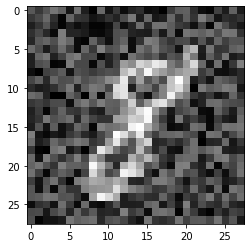

2**i=512


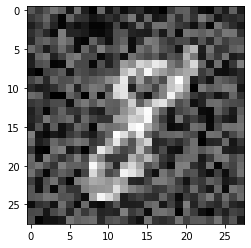

2**i=256


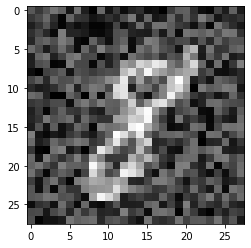

2**i=128


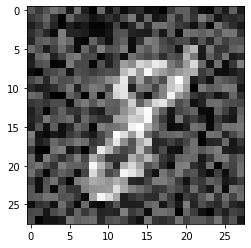

2**i=64


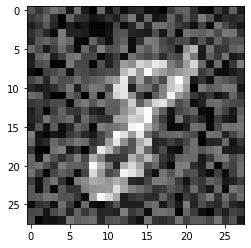

2**i=32


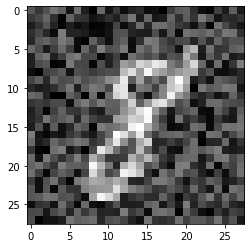

2**i=16


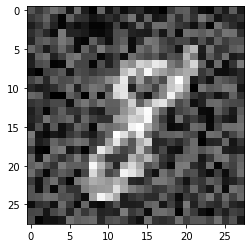

2**i=8


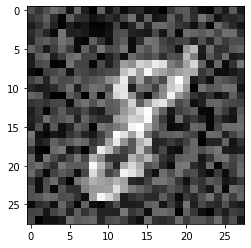

2**i=4


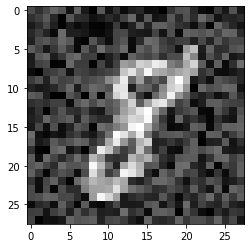

2**i=2


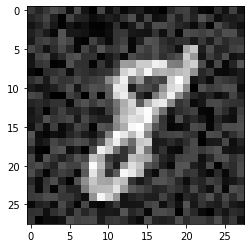

2**i=1


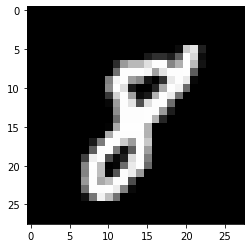

In [508]:
%matplotlib inline 

for i in range(10,-1, -1):
    
    temp = (final + target) - (final * 1/(2**i))
    plt.imshow(temp, cmap="gray")
    print(f'{2**i=}')
    plt.show()

2**i=1024


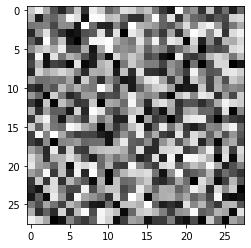

2**i=512


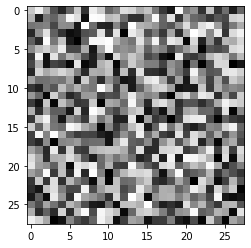

2**i=256


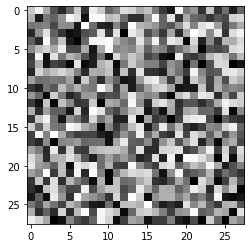

2**i=128


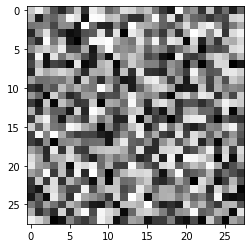

2**i=64


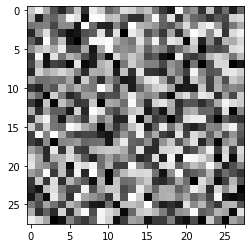

2**i=32


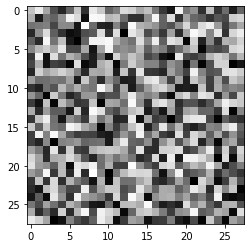

2**i=16


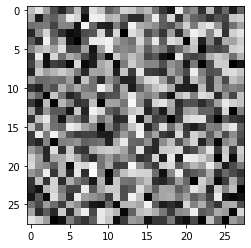

2**i=8


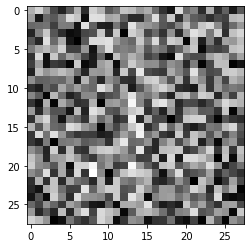

2**i=4


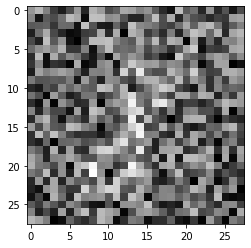

2**i=2


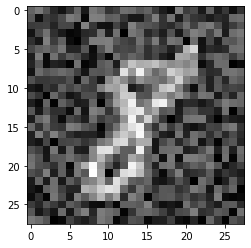

2**i=1


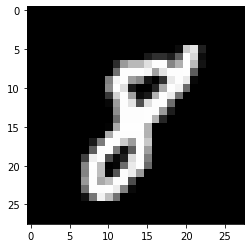

In [521]:
%matplotlib inline 

for i in range(10,-1, -1):
    
    temp = final - (final - target) * 1/(2**i)
    plt.imshow(temp, cmap="gray")
    print(f'{2**i=}')
    plt.show()
    

In [533]:
def is_adversarial_test(x):
    return x <= .3

In [550]:
epsilon_lower = 0
epsilon_upper = 1
epsilon = (epsilon_lower + epsilon_upper)/2

In [551]:
epsilon

0.5

In [554]:
1.4901161193847656e-08 - .915437534

-0.9154375190988389

In [573]:
boundary = .915437534

epsilon_lower = 1
epsilon_upper = 0
epsilon = (epsilon_lower + epsilon_upper)/2
while abs(epsilon - epsilon_lower) > .0001 or abs(epsilon - epsilon_upper) > .0001: 
    epsilon = (epsilon_lower + epsilon_upper)/2
    if epsilon <= boundary: 
        epsilon_upper = epsilon
    else: 
        epsilon_lower = epsilon
    print(f'{epsilon=}')
    print(f'{epsilon_upper=}')
    print(f'{epsilon_lower=}')

    

epsilon=0.5
epsilon_upper=0.5
epsilon_lower=1
epsilon=0.75
epsilon_upper=0.75
epsilon_lower=1
epsilon=0.875
epsilon_upper=0.875
epsilon_lower=1
epsilon=0.9375
epsilon_upper=0.875
epsilon_lower=0.9375
epsilon=0.90625
epsilon_upper=0.90625
epsilon_lower=0.9375
epsilon=0.921875
epsilon_upper=0.90625
epsilon_lower=0.921875
epsilon=0.9140625
epsilon_upper=0.9140625
epsilon_lower=0.921875
epsilon=0.91796875
epsilon_upper=0.9140625
epsilon_lower=0.91796875
epsilon=0.916015625
epsilon_upper=0.9140625
epsilon_lower=0.916015625
epsilon=0.9150390625
epsilon_upper=0.9150390625
epsilon_lower=0.916015625
epsilon=0.91552734375
epsilon_upper=0.9150390625
epsilon_lower=0.91552734375
epsilon=0.915283203125
epsilon_upper=0.915283203125
epsilon_lower=0.91552734375
epsilon=0.9154052734375
epsilon_upper=0.9154052734375
epsilon_lower=0.91552734375
epsilon=0.91546630859375
epsilon_upper=0.9154052734375
epsilon_lower=0.91546630859375


In [572]:
boundary = .015437534

epsilon_lower = 1
epsilon_upper = 0
epsilon = (epsilon_lower + epsilon_upper)/2
while abs(epsilon - epsilon_lower) > .0001 or abs(epsilon - epsilon_upper) > .0001: 
    epsilon = (epsilon_lower + epsilon_upper)/2
    if epsilon <= boundary: 
        epsilon_upper = epsilon
    else: 
        epsilon_lower = epsilon
    print(f'{epsilon=}')
    print(f'{epsilon_upper=}')
    print(f'{epsilon_lower=}\n')

    

epsilon=0.5
epsilon_upper=0
epsilon_lower=0.5

epsilon=0.25
epsilon_upper=0
epsilon_lower=0.25

epsilon=0.125
epsilon_upper=0
epsilon_lower=0.125

epsilon=0.0625
epsilon_upper=0
epsilon_lower=0.0625

epsilon=0.03125
epsilon_upper=0
epsilon_lower=0.03125

epsilon=0.015625
epsilon_upper=0
epsilon_lower=0.015625

epsilon=0.0078125
epsilon_upper=0.0078125
epsilon_lower=0.015625

epsilon=0.01171875
epsilon_upper=0.01171875
epsilon_lower=0.015625

epsilon=0.013671875
epsilon_upper=0.013671875
epsilon_lower=0.015625

epsilon=0.0146484375
epsilon_upper=0.0146484375
epsilon_lower=0.015625

epsilon=0.01513671875
epsilon_upper=0.01513671875
epsilon_lower=0.015625

epsilon=0.015380859375
epsilon_upper=0.015380859375
epsilon_lower=0.015625

epsilon=0.0155029296875
epsilon_upper=0.015380859375
epsilon_lower=0.0155029296875

epsilon=0.01544189453125
epsilon_upper=0.015380859375
epsilon_lower=0.01544189453125



In [568]:
(epsilon - epsilon_upper)

0.5

In [569]:
(epsilon - epsilon_lower)

-0.5

In [567]:
(epsilon - epsilon_upper) > .001 and (epsilon - epsilon_lower) > .001

False